In [1]:
import os
import sys
import math
import random
import argparse
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn.functional as F
import torch.autograd as autograd

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Distribution functions (from *samplers.py*)

In [3]:
def distribution1(x, batch_size=512):
    # Distribution defined as (x, U(0,1)). Can be used for question 3
    while True:
        yield (np.array(
            [(x, random.uniform(0, 1)) for _ in range(batch_size)]))

In [4]:
def distribution2(batch_size=512):
    # High dimension uniform distribution
    while True:
        yield (np.random.uniform(0, 1, (batch_size, 2)))

# Question 1

In [5]:
def JSD_objective(D, x, y):
    D_x = D.forward(x)
    D_y = D.forward(y)
    return math.log(2) + 0.5 * (torch.mean(
        torch.log(D_x))) + 0.5 * (torch.mean(torch.log(1 - D_y)))

# Question 2

In [6]:
# Calculates the gradient penalty loss for WGAN GP
def compute_gradient_penalty(D, x, y):
    # Random weight term for interpolation between real and fake samples
    alpha = torch.randn(x.size(0), 1).to(device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * x + ((1 - alpha) * y)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(x.shape[0], 1).to(device)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1)**2).mean()
    return gradient_penalty

In [7]:
def WD_gp_objective(D, x, y):
    lambda_gp = 10
    D_x = D.forward(x)
    D_y = D.forward(y)
    return torch.mean(D_x) - torch.mean(
        D_y) - lambda_gp * compute_gradient_penalty(D, x, y)

# Question 3

In [8]:
d_input_size = 2
d_hidden_size = 75   
d_output_size = 1

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.elu = torch.nn.ELU()
    
    def forward(self, x):
        x = self.elu(self.map1(x))
        x = self.elu(self.map2(x))
        return torch.sigmoid( self.map3(x) )

In [9]:
D = Discriminator(
    input_size=d_input_size,
    hidden_size=d_hidden_size,
    output_size=d_output_size).to(device)
d_optimizer = optim.SGD(D.parameters(), lr=0.001)

In [10]:
def distance_estimate(dist1, dist2, n_epochs=1000, Wasserstein=False):
    objective = WD_gp_objective if Wasserstein else JSD_objective
    samplesx, samplesy = [], []
    for i, (d1, d2) in enumerate(zip(dist1, dist2)):
        if i >= n_epochs:
            break
        samplesx.append(d1)
        samplesy.append(d2)

    samplesx = torch.from_numpy(np.asarray(samplesx)).float().to(device)
    samplesy = torch.from_numpy(np.asarray(samplesy)).float().to(device)

    for x, y in zip(samplesx, samplesy):
        d_optimizer.zero_grad()
        loss_D = -objective(D, x, y)
        loss_D.backward()
        d_optimizer.step()
    return -loss_D.item()

In [11]:
dist1 = iter(distribution1(0))

n_epochs = 1000

y_axis_JSD = []
y_axis_W = []
phi = np.arange(-1, 1, 0.1)

for p in phi:
    dist1 = iter(distribution1(0))
    dist2 = iter(distribution1(p))
    y_axis_JSD.append(distance_estimate(dist1, dist2, n_epochs, False))
    y_axis_W.append(distance_estimate(dist1, dist2, n_epochs, True))

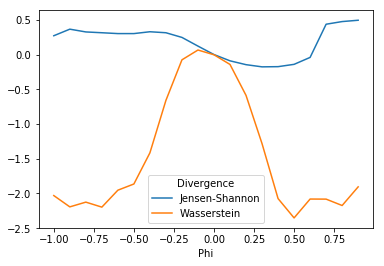

In [12]:
plt.plot(phi, y_axis_JSD, label="Jensen-Shannon")
plt.plot(phi, y_axis_W, label="Wasserstein")
plt.legend(title="Divergence")
plt.xlabel("Phi")
plt.show()